These imports are required for the training and evaluation of the model

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn import linear_model
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import f1_score
from sklearn import manifold

The next cell load and clean data for a model used to predict whether or not a subject will survive until the end of the study. This was a prelimenary step used by the developers of this application to identify features to use in our final model. 

In [5]:
csv = pd.read_csv('../data/PER_PATIENT.csv')
data = csv[['D_PT_gender', 'D_PT_age', 'CREATININE', 'D_PT_therclassn', 'sctflag', 'D_PT_iss', 'D_PT_PRIMARYREASON']]
data['D_PT_PRIMARYREASON'] = data['D_PT_PRIMARYREASON'].fillna(value=0)
data = data.dropna()

data = data.replace({'Death': 1})

data = data[(data['D_PT_PRIMARYREASON'] == 1) | (data['D_PT_PRIMARYREASON'] == 0)]
X = data[['D_PT_gender', 'D_PT_age', 'CREATININE', 'D_PT_therclassn', 'sctflag', 'D_PT_iss']]
y = data['D_PT_PRIMARYREASON'].astype(int)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Here we present a table of several patient visits used for the training of this model. Refer to the documentation for explanation on feature interpretation. All categorical features were convereted to numeric values for the purpose of model training. 

In [6]:
data[:10]

,D_PT_gender,D_PT_age,CREATININE,D_PT_therclassn,sctflag,D_PT_iss,D_PT_PRIMARYREASON
1,1,75.0,79.56,3.0,0.0,1.0,1
2,2,79.0,123.76,1.0,0.0,2.0,0
3,1,69.0,97.24,3.0,0.0,3.0,0
4,1,64.0,79.56,3.0,0.0,1.0,0
5,1,78.0,176.80,1.0,0.0,3.0,1
6,1,74.0,97.24,1.0,0.0,2.0,1
7,1,47.0,159.12,1.0,1.0,2.0,1
8,2,59.0,88.40,1.0,1.0,2.0,0
9,2,66.0,53.04,3.0,0.0,1.0,0
10,1,81.0,70.72,3.0,0.0,1.0,1


Finally, we train the model using a support vector machine with a linear kernel and balanced class weights and achieve an accuracy score of 0.71 on the test set.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = SVC(C=0.01, kernel='linear', class_weight='balanced')
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.7102473498233216

Now we present the more complex pipeline for disease progression prediction. First, we load and clean data.

In [8]:
test = pd.read_csv("../data/PER_PATIENT_VISIT.csv")
work = test[ [
'PUBLIC_ID',
'D_LAB_chem_totprot',
'D_LAB_chem_creatinine',
'D_LAB_chem_calcium',
'D_LAB_chem_bun',
'D_LAB_chem_albumin',
'D_LAB_cbc_abs_neut',
'D_LAB_serum_iga',
'D_LAB_chem_glucose',
'D_LAB_cbc_hemoglobin',
'D_LAB_cbc_platelet',
'D_LAB_cbc_wbc',
'D_TRI_CF_WASCYTOGENICS',

'AT_TREATMENTRESP'] ]

work = work[pd.notnull(work['AT_TREATMENTRESP'])]

work = work.replace({'Stable Disease': 0, 'Partial Response': 0, 'Very Good Partial Response (VGPR)': 0, 'Progressive Disease': 1, 'Complete Response': 0, 'Stringent Complete Response (sCR)': 0})
work = work.replace({'No': 0, 'Yes': 1})

#work = work.dropna()

work.PUBLIC_ID = work.PUBLIC_ID.apply(lambda x: int(x[-4:]))
X = work[[
'PUBLIC_ID',
'D_LAB_chem_totprot',
'D_LAB_chem_creatinine',
'D_LAB_chem_calcium',
'D_LAB_chem_bun',
'D_LAB_chem_albumin',
'D_LAB_cbc_abs_neut',
'D_LAB_serum_iga',
'D_LAB_chem_glucose',
'D_LAB_cbc_hemoglobin',
'D_LAB_cbc_platelet',
'D_LAB_cbc_wbc',
'D_TRI_CF_WASCYTOGENICS'
]]

Y = work['AT_TREATMENTRESP']

imputer = Imputer()
X = imputer.fit_transform(X)

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (11,13,14,48,49,52,54,55,57,58,59,60,80,87,91,94,103,107,110,114,117,119,123,124,127,155,157,159,174,181,182,185,210,211,224,232,235,237,238,239,240,265,299,312,441,444,446,448,455,458,462,477,480,484,485,486,492,502,512,514,516,519,521,523,526,530,533,535,537,540,542,544,554,556,558,561,563,565,568,570,595,596,598,599,600,601,604,605,610) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Now we split the data into training and testing, and train the model. We performed hyperparameter selection across kernels and regularization values for our SVM. In the end, the SVM with a linear kernel and a cost value of 0.01 performed best.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)#, random_state=42)

for k in ['linear']:
    for c in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
        clf = SVC(C=c, kernel=k, class_weight='balanced')
        clf.fit(X_train, y_train) 

        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        print k, c, "Acc:", accuracy_score(y_test, y_pred)
        print 'F1 score: {0:0.2f}'.format(f1)
        
        print 'True stable:', cm[0][0]
        print 'False stable:', cm[0][1]
        print 'True Progression:', cm[1][1]
        print 'False Progression:', cm[1][0]
        print ''


linear 0.0001 Acc: 0.702485966319166
F1 score: 0.23
True stable: 821
False stable: 320
True Progression: 55
False Progression: 51

linear 0.001 Acc: 0.7554129911788292
F1 score: 0.25
True stable: 892
False stable: 249
True Progression: 50
False Progression: 56

linear 0.01 Acc: 0.7858861267040899
F1 score: 0.29
True stable: 926
False stable: 215
True Progression: 54
False Progression: 52

linear 0.1 Acc: 0.7345629510825983
F1 score: 0.27
True stable: 856
False stable: 285
True Progression: 60
False Progression: 46

linear 1 Acc: 0.6663993584603047
F1 score: 0.25
True stable: 762
False stable: 379
True Progression: 69
False Progression: 37

linear 10 Acc: 0.6792301523656776
F1 score: 0.27
True stable: 774
False stable: 367
True Progression: 73
False Progression: 33



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)#, random_state=42)

for k in ['rbf']:
    for c in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
        clf = SVC(C=c, kernel=k, class_weight='balanced')
        clf.fit(X_train, y_train) 

        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        print k, c, "Acc:", accuracy_score(y_test, y_pred)
        print 'F1 score: {0:0.2f}'.format(f1)
        
        print 'True stable:', cm[0][0]
        print 'False stable:', cm[0][1]
        print 'True Progression:', cm[1][1]
        print 'False Progression:', cm[1][0]
        print ''
        print cm

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


rbf 0.0001 Acc: 0.9230152365677626
F1 score: 0.00
True stable: 1151
False stable: 0
True Progression: 0
False Progression: 96

[[1151    0]
 [  96    0]]
rbf 0.001 Acc: 0.9230152365677626
F1 score: 0.00
True stable: 1151
False stable: 0
True Progression: 0
False Progression: 96

[[1151    0]
 [  96    0]]
rbf 0.01 Acc: 0.07698476343223737
F1 score: 0.14
True stable: 0
False stable: 1151
True Progression: 96
False Progression: 0

[[   0 1151]
 [   0   96]]
rbf 0.1 Acc: 0.9230152365677626
F1 score: 0.00
True stable: 1151
False stable: 0
True Progression: 0
False Progression: 96

[[1151    0]
 [  96    0]]
rbf 1 Acc: 0.9230152365677626
F1 score: 0.00
True stable: 1151
False stable: 0
True Progression: 0
False Progression: 96

[[1151    0]
 [  96    0]]
rbf 10 Acc: 0.9230152365677626
F1 score: 0.00
True stable: 1151
False stable: 0
True Progression: 0
False Progression: 96

[[1151    0]
 [  96    0]]


In [13]:
fig = plt.figure(figsize=(15, 8))
colors = [1, 2]
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_fit = tsne.fit_transform(X)

<Figure size 1080x576 with 0 Axes>

(6233, 13) (6233,)


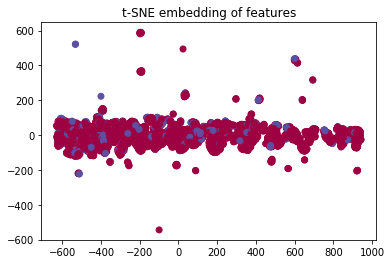

In [14]:
#ax = fig.add_subplot(2, 5, 10)
print X.shape, Y.shape
plt.scatter(X_fit[:, 0], X_fit[:, 1], c = Y, cmap=plt.cm.Spectral)
plt.title("t-SNE embedding of features")
plt.show()